In [1]:


training_name = 'training-toy-version2b'

testmode = False
#testmode = True

run_training = True
run_training = False


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import sys
from IPython import display


#-- this selects the first GPU
os.environ['CUDA_VISIBLE_DEVICES']="1"

from os import listdir

from pickle import dump
from pickle import load

import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras

from tensorflow.python.client import device_lib

from pickle import dump


#has_gpu = False

has_gpu = True



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    #os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


    print("\n\n printing physical devbices from tf.config.list_physical_devices\n\n")
    print(physical_devices)

    devices = device_lib.list_local_devices()

    print("\n\n printing devices from device_lib.list_local_devices\n\n")
    print(devices)


2023-10-05 10:49:50.856578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing physical devbices from tf.config.list_physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing devices from device_lib.list_local_devices


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18138693337051396883
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23344578560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8435600506010383897
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-10-05 10:49:50.875553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:50.875801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:50.879930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:50.880123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:50.880295: I tensorflow/compiler/xla/stream_executo

## Generate toy data

In [4]:
#ntoy = 100000

#ntoy = 400000

ntoy = 1000000

#mu_min = -1.
#mu_max = 1.


mu_min = -3.
mu_max = 3.






#z0_sig = 1.0
#z1_sig = 0.2

#x0_sig = 0.2
#x1_sig = 1.0





z0_sig = 0.5
z1_sig = 0.1

x0_sig = 0.1
x1_sig = 0.5






#z0_sig = 0.3
#z1_sig = 0.1

#x0_sig = 0.1
#x1_sig = 0.3




mu = np.random.uniform(mu_min, mu_max, ntoy)


z0 = np.random.normal(mu,z0_sig)
z1 = np.random.normal(mu,z1_sig)


x0 = np.random.normal(z0, x0_sig)
x1 = np.random.normal(z1, x1_sig)



In [5]:
diff_z0 = mu - z0

<function matplotlib.pyplot.show(close=None, block=None)>

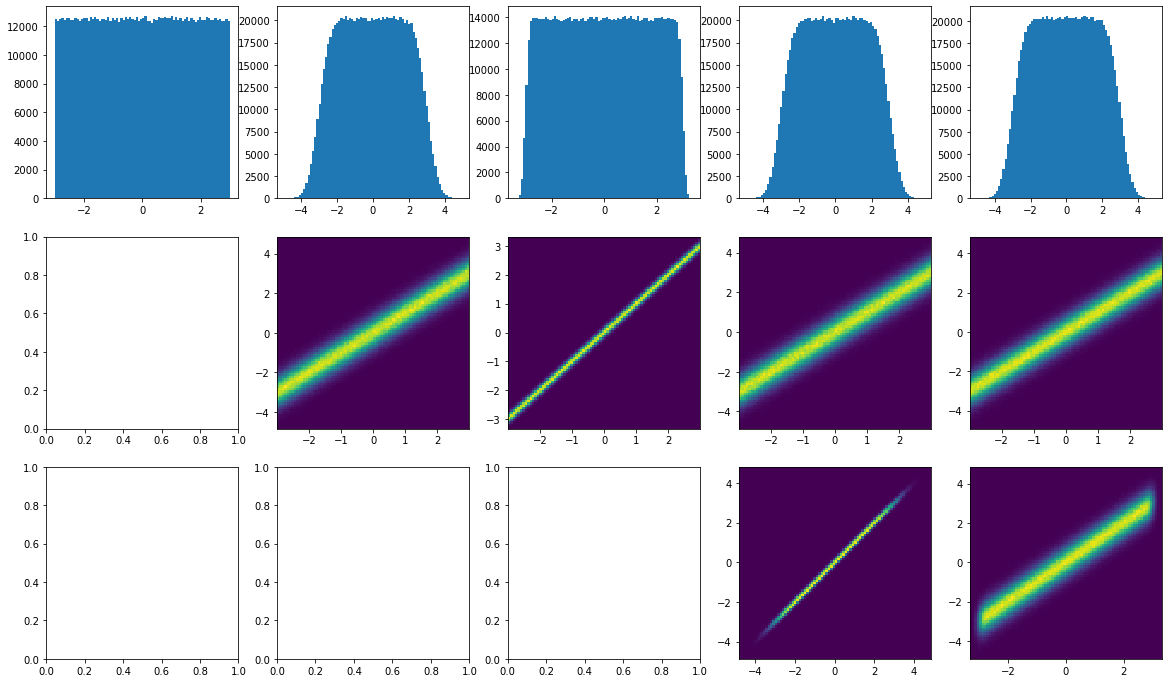

In [6]:
fig,ax = plt.subplots(3,5,figsize=(20,12))

ax[0][0].hist(mu, bins=80)
ax[0][1].hist(z0, bins=80)
ax[0][2].hist(z1, bins=80)
ax[0][3].hist(x0, bins=80)
ax[0][4].hist(x1, bins=80)


ax[1][1].hist2d(mu,z0, bins=[80,80])
ax[1][2].hist2d(mu,z1, bins=[80,80])
ax[1][3].hist2d(mu,x0, bins=[80,80])
ax[1][4].hist2d(mu,x1, bins=[80,80])

ax[2][3].hist2d(z0,x0, bins=[80,80])
ax[2][4].hist2d(z1,x1, bins=[80,80])


plt.show

In [7]:


if run_training :
    
    try:
        os.mkdir( '%s-training-output' % training_name )
    except:
        print('\n  Dir %s-training-output already exists\n\n' % training_name )
        #print('\n\n HALTING EXECUTION \n\n')
        #sys.exit()


learning_rate_setval = 5e-5
batch_size_setval = 512
max_epochs = 5000
amsgrad_setval = False
patience_setval = 40
hp_lambda = 1.0

if testmode :

#-- settings for quick syntax checking runthrough
    max_events =   600000
    learning_rate_setval = 1e-3
    batch_size_setval = 4096
    max_epochs = 200








output_dir = '%s-training-output' % training_name





In [8]:
X = np.c_[
    z0,
    z1,
    x0,
    x1,
]

Y = np.c_[
    mu
]

In [9]:
scaler_file = "%s/input-scaler.pkl" % output_dir

if run_training :
    print("Creating new scaler.")
    scalerX = StandardScaler()
    scalerX.fit(X)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX = load( open(scaler_file, 'rb') )
    
Xs = scalerX.transform(X)


if run_training :
    print("Saving scaler to %s" % scaler_file)
    dump( scalerX, open(scaler_file, 'wb'))


Reading scaler from file: training-toy-version2b-training-output/input-scaler.pkl


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split( Xs, Y, test_size=0.5 )
#X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.5 )

<function matplotlib.pyplot.show(close=None, block=None)>

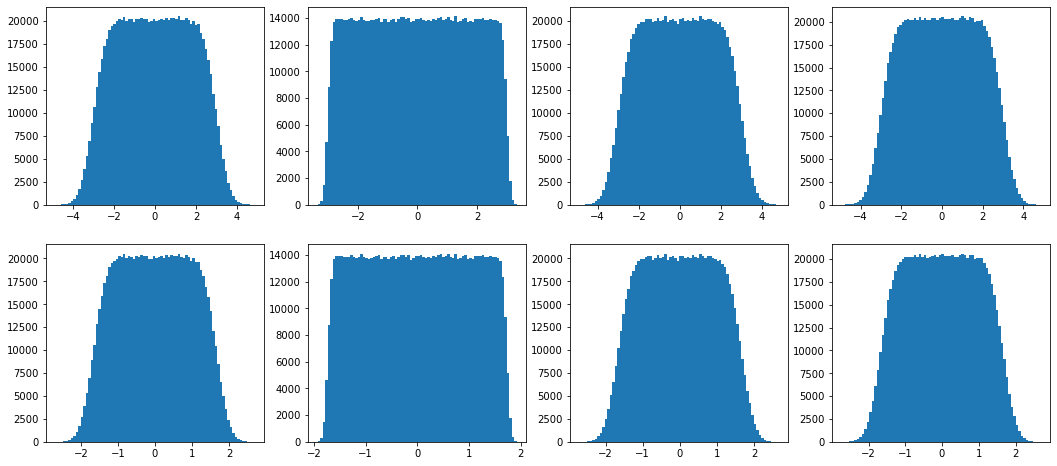

In [11]:
fig,ax = plt.subplots(2,4,figsize=(18,8))


ax[0][0].hist( X[:,0], bins=80)
ax[0][1].hist( X[:,1], bins=80)
ax[0][2].hist( X[:,2], bins=80)
ax[0][3].hist( X[:,3], bins=80)

ax[1][0].hist( Xs[:,0], bins=80)
ax[1][1].hist( Xs[:,1], bins=80)
ax[1][2].hist( Xs[:,2], bins=80)
ax[1][3].hist( Xs[:,3], bins=80)

plt.show

In [12]:
X_train

array([[-1.12308562, -0.96283559, -1.07225222, -0.56857739],
       [ 0.52305898,  0.42246812,  0.49039336,  0.20760532],
       [ 0.65262538,  0.85764463,  0.55996201,  0.93960558],
       ...,
       [-1.33955827, -1.55879791, -1.43699201, -1.7620957 ],
       [ 0.39735353,  0.58129156,  0.37058383,  0.81301101],
       [ 0.95479697,  1.30674115,  1.02934259,  1.60209493]])

In [13]:
Y_train

array([[-1.84003107],
       [ 0.72122791],
       [ 1.40807368],
       ...,
       [-2.59921103],
       [ 1.07082761],
       [ 2.13920075]])

In [14]:
np.shape(X_train)

(500000, 4)

In [15]:
np.shape(Y_train)

(500000, 1)

In [16]:
def train_model( mse_sf ) :
    
    huber = tf.keras.losses.Huber(delta=10)
    
    def custom_loss(y_true, y_pred):
        particle_level = y_pred[:,0]
        detector_level = y_pred[:,1]
        #loss =  huber(y_true, particle_level) + mse_sf * tf.reduce_mean(tf.square(particle_level - detector_level)) 
        loss =  huber(y_true, detector_level) + mse_sf * tf.reduce_mean(tf.square(particle_level - detector_level)) 
        return loss    

    n = 2  # Number of features in input.

    inputs = Input(shape=(2*n,))

    classifier_nn = Sequential()
    classifier_nn.add( Dense( 50, activation="relu", input_dim=n) )
    classifier_nn.add( Dense( 50, activation="relu"))
    classifier_nn.add( Dense( 1, activation="linear"))

    particle_inputs_model2 = classifier_nn( inputs[:,0:n] )
    detector_inputs_model2 = classifier_nn( inputs[:,n:] )

    output2 = tf.stack( [particle_inputs_model2, detector_inputs_model2], axis=1)


    mymodel2 = Model( inputs=[inputs], outputs=[output2])


    opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

    mymodel2.compile( loss=custom_loss, optimizer=opt_adam, metrics=['accuracy'] )


    
    
    training_hist2 = mymodel2.fit( X_train, Y_train, validation_data=(X_test, Y_test), 
            epochs=50, 
            batch_size=batch_size_setval,
           verbose=1)

    plt.plot( training_hist2.history['loss'] )
    plt.plot( training_hist2.history['val_loss'] )
    
    mymodel2.summary()
    
    return mymodel2
    

In [17]:
num_sf = 6

sf_val = [0., 0.2, 0.6, 1., 2., 4. ]

sf_ind = 0

In [18]:
%%time

model_sf_array = []

if run_training :
    for sfi in range(0, num_sf) :
        print("\n\n =============== Training with SF = ", sf_val[sfi], "\n\n" )
        model = train_model( sf_val[sfi])
        model_sf_array.append(model)
        tf.keras.models.save_model( model, "%s/model-sf-%.1f" % (output_dir, sf_val[sfi] ) )
else :
    for sfi in range(0, num_sf) :
        print("\n ======= Loading model for SF = ", sf_val[sfi],"\n\n")
        model = tf.keras.models.load_model( "%s/model-sf-%.1f" % (output_dir, sf_val[sfi] ), compile=False )
        model_sf_array.append(model)


 ======= Loading model for SF =  0.0 




2023-10-05 10:49:54.150133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:54.150382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:54.150555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:54.150777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:49:54.150954: I tensorflow/compiler/xla/stream_executo


 ======= Loading model for SF =  0.2 



 ======= Loading model for SF =  0.6 



 ======= Loading model for SF =  1.0 



 ======= Loading model for SF =  2.0 



 ======= Loading model for SF =  4.0 


CPU times: user 1.24 s, sys: 196 ms, total: 1.43 s
Wall time: 1.42 s


In [19]:
preds = []

for sfi in range(0, num_sf) :
    
    preds.append( model_sf_array[sfi].predict( X_test, batch_size=1024 ) )

155/489 [========>.....................] - ETA: 0s

2023-10-05 10:49:56.238724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


489/489 [==============================] - 0s 633us/step


<function matplotlib.pyplot.show(close=None, block=None)>

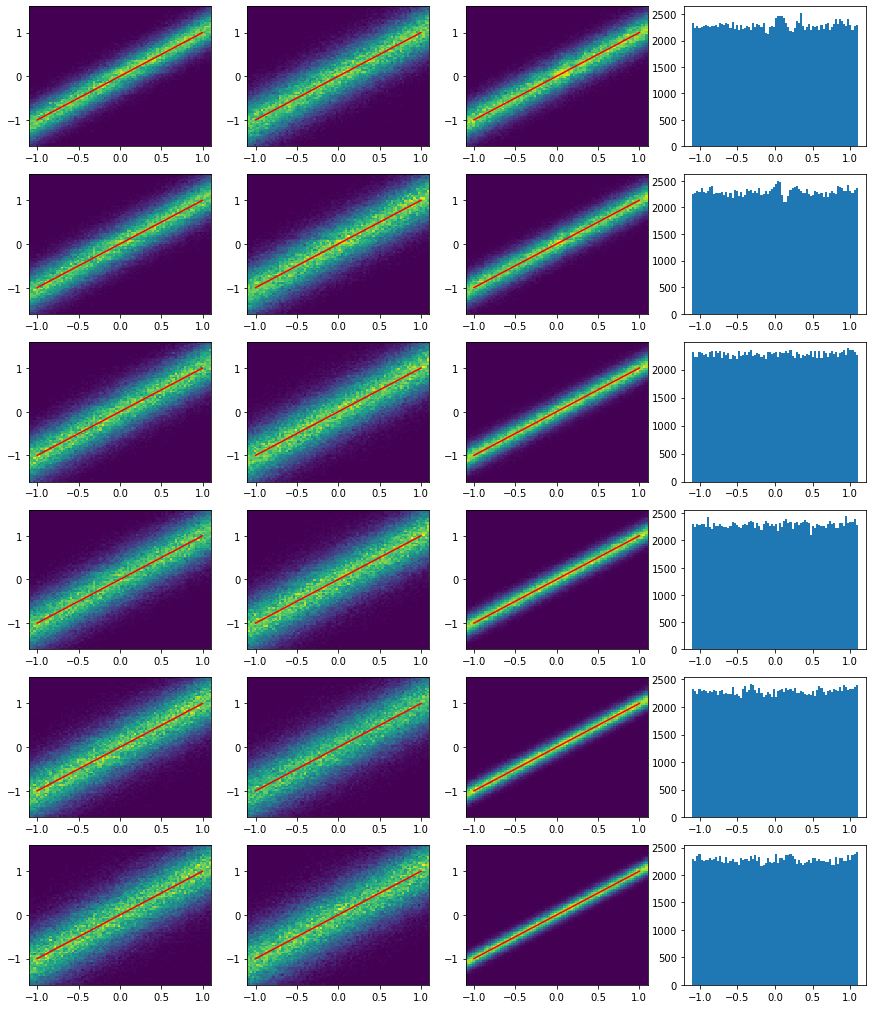

In [20]:
fig,ax = plt.subplots(num_sf,4,figsize=(15,18))

plotrange = 0

if plotrange == 0:

    plot_xmin = -1.1
    plot_xmax = 1.1

    plot_ymin = -1.6
    plot_ymax = 1.6


if plotrange == 1:
    
    plot_xmin = -3
    plot_xmax = 3

    plot_ymin = -3.6
    plot_ymax = 3.6



for sfi in range(0, num_sf) :

    ax[sfi][0].hist2d( Y_test[:,0], preds[sfi][:,0][Y_test>-9], bins=[80,80], 
                      range=([plot_xmin, plot_xmax],[plot_ymin, plot_ymax]))
    ax[sfi][1].hist2d( Y_test[:,0], preds[sfi][:,1][Y_test>-9], bins=[80,80],
                      range=([plot_xmin, plot_xmax],[plot_ymin, plot_ymax]))
    ax[sfi][2].hist2d( preds[sfi][:,0][Y_test>-9], preds[sfi][:,1][Y_test>-9], bins=[80,80], 
                      range=([plot_xmin, plot_xmax],[plot_ymin, plot_ymax]))
    ax[sfi][3].hist( preds[sfi][:,1], bins=80, range=[plot_xmin, plot_xmax])

    ax[sfi][0].plot( [-1.,1.],[-1.,1.], color="red")
    ax[sfi][1].plot( [-1.,1.],[-1.,1.], color="red")
    ax[sfi][2].plot( [-1.,1.],[-1.,1.], color="red")


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

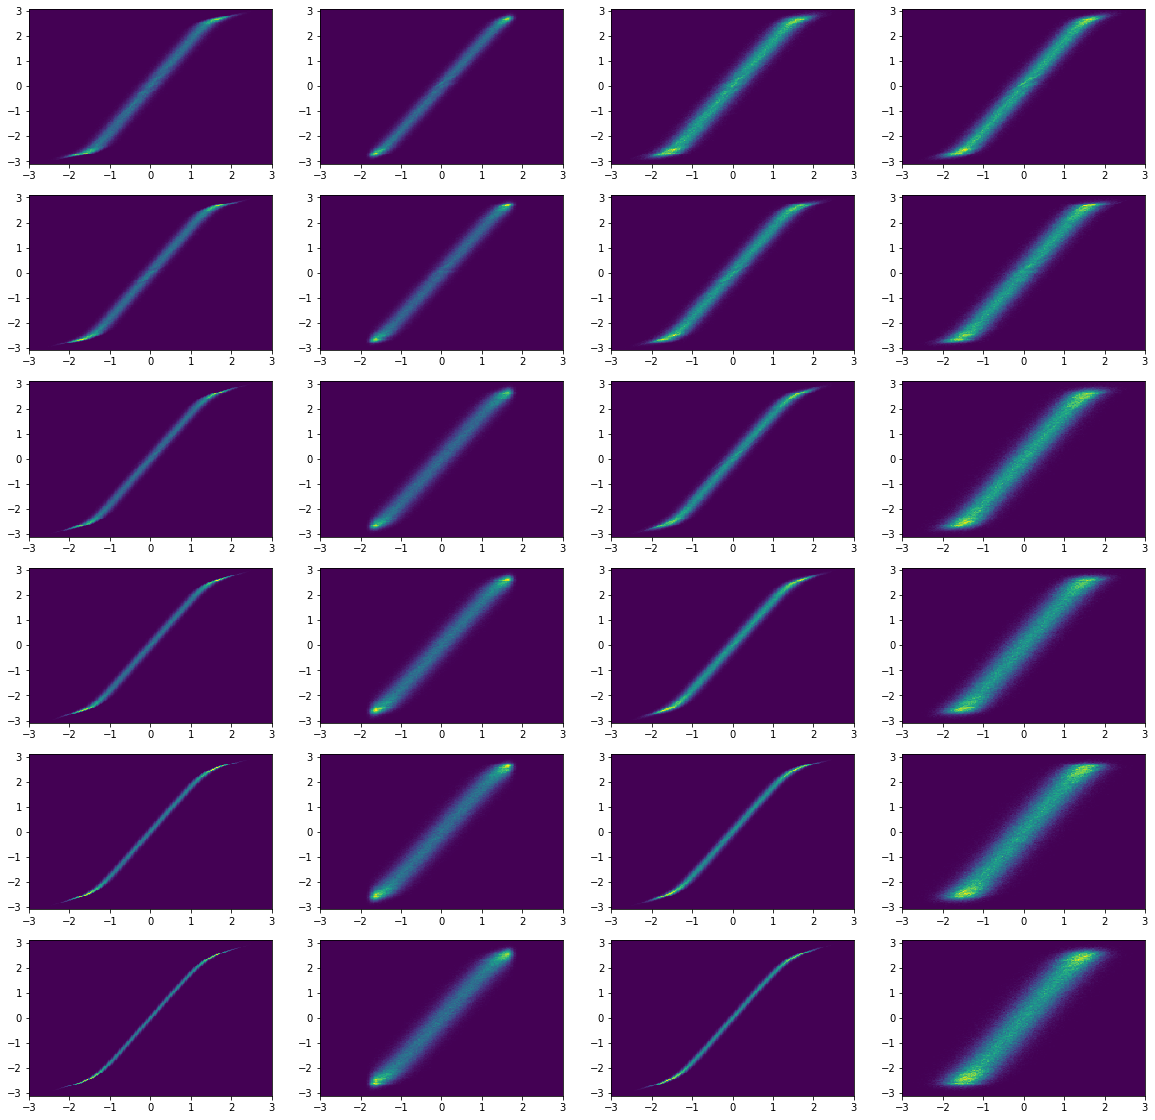

In [21]:
fig,ax = plt.subplots(num_sf,4,figsize=(20,20))

plotxmin = -3.0
plotxmax = 3.0

plotymin = -3.1
plotymax = 3.1

for sfi in range(0, num_sf) :

    ax[sfi][0].hist2d( X_test[:,0], preds[sfi][:,0][Y_test>-9], bins=[180,180], range=([plotxmin, plotxmax],[plotymin, plotymax]))
    ax[sfi][1].hist2d( X_test[:,1], preds[sfi][:,0][Y_test>-9], bins=[180,180], range=([plotxmin, plotxmax],[plotymin, plotymax]))
    ax[sfi][2].hist2d( X_test[:,2], preds[sfi][:,1][Y_test>-9], bins=[180,180], range=([plotxmin, plotxmax],[plotymin, plotymax]))
    ax[sfi][3].hist2d( X_test[:,3], preds[sfi][:,1][Y_test>-9], bins=[180,180], range=([plotxmin, plotxmax],[plotymin, plotymax]))



plt.show

## Correlation analysis between input features and NN output

In [22]:
def calc_core_correlation( a, b ) -> float :
    
    nevts = np.shape(a)[0]
    
    asum = 0
    bsum = 0
    absum = 0
    aasum = 0
    bbsum = 0

    npass = 0

    for i in range(0,nevts) :
        aval = a[i]
        bval = b[i]
        if ( aval > 1 ) : continue
        if ( bval > 1 ) : continue
        if ( aval < -1 ) : continue
        if ( bval < -1 ) : continue
        #if ( i < 20 ) : print( "a = %7.3f  b = %7.3f" % (aval, bval))
        asum = asum + aval
        bsum = bsum + bval
        absum = absum + aval*bval
        aasum = aasum + aval*aval
        bbsum = bbsum + bval*bval
        npass = npass + 1

    avea = asum / npass
    aveb = bsum / npass

    aveab = absum / npass
    aveaa = aasum / npass
    avebb = bbsum / npass

    arms = np.sqrt( aveaa - avea*avea )
    brms = np.sqrt( avebb - aveb*aveb )

    rho =  ( aveab - avea*aveb ) / (arms*brms)

    #print("  number in sums: %d" % npass )
    #print("  a mean = %7.3f , b mean = %7.3f" % (avea, aveb))
    #print("  a rms = %7.3f, b rms = %7.3f" % (arms, brms))
    #print("  rho = %7.3f" % rho )
    
    return rho


In [23]:

rho_z0_nnz_vals = []
rho_z1_nnz_vals = []

rho_x0_nnx_vals = []
rho_x1_nnx_vals = []




for sfi in range(0, num_sf) :

    b = preds[sfi][:,0]
    
    a = X_test[:,0]
    rho_z0_nnz = calc_core_correlation( a, b )
    rho_z0_nnz_vals.append(rho_z0_nnz)
    
    a = X_test[:,1]
    rho_z1_nnz = calc_core_correlation( a, b )
    rho_z1_nnz_vals.append(rho_z1_nnz)

    b = preds[sfi][:,1]
    
    a = X_test[:,2]
    rho_x0_nnx = calc_core_correlation( a, b )
    rho_x0_nnx_vals.append(rho_x0_nnx)
    
    a = X_test[:,3]
    rho_x1_nnx = calc_core_correlation( a, b )
    rho_x1_nnx_vals.append(rho_x1_nnx)
    
    print( " sfi %d   %4.1f :  rho(z0,nnz) = %6.3f   rho(z1,nnz) = %6.3f    rho(x0,nnx) = %6.3f    rho(x1,nnx) = %6.3f"
          % ( sfi, sf_val[sfi], rho_z0_nnz, rho_z1_nnz, rho_x0_nnx, rho_x1_nnx ) )
    

 sfi 0    0.0 :  rho(z0,nnz) =  0.907   rho(z1,nnz) =  0.917    rho(x0,nnx) =  0.846    rho(x1,nnx) =  0.851
 sfi 1    0.2 :  rho(z0,nnz) =  0.934   rho(z1,nnz) =  0.890    rho(x0,nnx) =  0.887    rho(x1,nnx) =  0.809
 sfi 2    0.6 :  rho(z0,nnz) =  0.959   rho(z1,nnz) =  0.857    rho(x0,nnx) =  0.927    rho(x1,nnx) =  0.760
 sfi 3    1.0 :  rho(z0,nnz) =  0.972   rho(z1,nnz) =  0.840    rho(x0,nnx) =  0.949    rho(x1,nnx) =  0.734
 sfi 4    2.0 :  rho(z0,nnz) =  0.985   rho(z1,nnz) =  0.813    rho(x0,nnx) =  0.972    rho(x1,nnx) =  0.694
 sfi 5    4.0 :  rho(z0,nnz) =  0.993   rho(z1,nnz) =  0.791    rho(x0,nnx) =  0.986    rho(x1,nnx) =  0.663


## Generate new nominal data and alternate detector response data at specific mu

In [24]:
mu_val = 1.0
ngen = 1000000

alt_x0_sig = 1.4 * x0_sig
alt_x1_sig = 1.4 * x1_sig

#alt_x0_mean = 0.4 * x0_sig
alt_x0_mean = 0.0
alt_x1_mean = 0.4 * x1_sig



fixedmu_z0 = np.random.normal( mu_val, z0_sig, ngen )
fixedmu_z1 = np.random.normal( mu_val, z1_sig, ngen )


fixedmu_x0 = np.random.normal( fixedmu_z0, x0_sig )
fixedmu_x1 = np.random.normal( fixedmu_z1, x1_sig )

resfun_x0 = np.random.normal( 0., x0_sig, ngen )
resfun_x1 = np.random.normal( 0., x1_sig, ngen )

alt_resfun_x0 = np.random.normal( alt_x0_mean, alt_x0_sig, ngen )
alt_resfun_x1 = np.random.normal( alt_x1_mean, alt_x1_sig, ngen )

fixedmu_X = np.c_[
    fixedmu_z0,
    fixedmu_z1,
    fixedmu_x0,
    fixedmu_x1,
]

fixedmu_Xs = scalerX.transform( fixedmu_X )

fixedmu_preds = []

for sfi in range(0, num_sf) :
    
    fixedmu_preds.append( model_sf_array[sfi].predict( fixedmu_Xs, batch_size=1024 ) )


977/977 [==============================] - 1s 614us/step


In [25]:


print("")
print(" x0 resolution: nominal sigma %6.3f, alt sigma %6.3f,  alt mean %6.3f" % (x0_sig, alt_x0_sig, alt_x0_mean))
print(" x1 resolution: nominal sigma %6.3f, alt sigma %6.3f,  alt mean %6.3f" % (x1_sig, alt_x1_sig, alt_x1_mean))
print("")

alt_fixedmu_x0 = np.random.normal( fixedmu_z0 + alt_x0_mean, alt_x0_sig )
alt_fixedmu_x1 = np.random.normal( fixedmu_z1 + alt_x1_mean, alt_x1_sig )


alt_fixedmu_X = np.c_[
    fixedmu_z0,
    fixedmu_z1,
    alt_fixedmu_x0,
    alt_fixedmu_x1,
]

alt_fixedmu_Xs = scalerX.transform( alt_fixedmu_X )

alt_fixedmu_preds = []

for sfi in range(0, num_sf) :
    
    alt_fixedmu_preds.append( model_sf_array[sfi].predict( alt_fixedmu_Xs, batch_size=1024 ) )




 x0 resolution: nominal sigma  0.100, alt sigma  0.140,  alt mean  0.000
 x1 resolution: nominal sigma  0.500, alt sigma  0.700,  alt mean  0.200

977/977 [==============================] - 1s 635us/step


<function matplotlib.pyplot.show(close=None, block=None)>

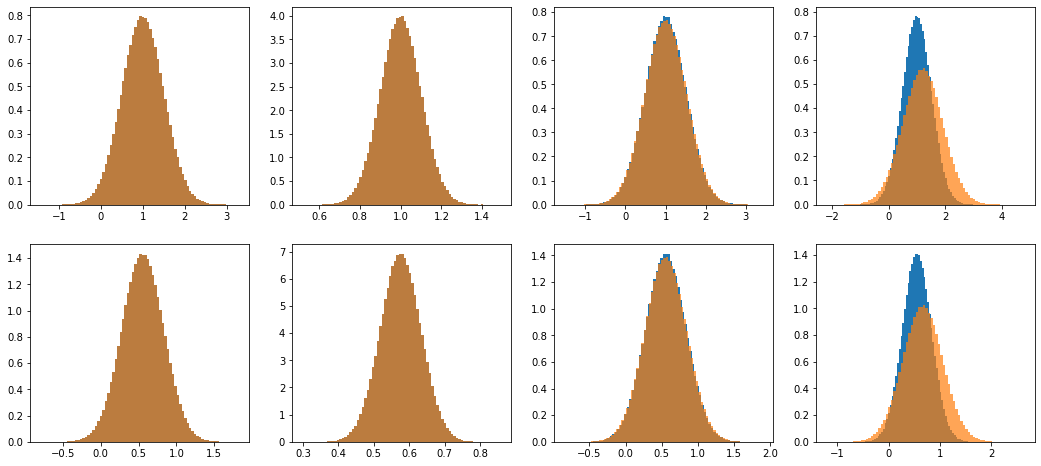

In [26]:
fig,ax = plt.subplots(2,4,figsize=(18,8))


ax[0][0].hist( fixedmu_X[:,0], bins=80, density=True )
ax[0][1].hist( fixedmu_X[:,1], bins=80, density=True)
ax[0][2].hist( fixedmu_X[:,2], bins=80, density=True)
ax[0][3].hist( fixedmu_X[:,3], bins=80, density=True)

ax[1][0].hist( fixedmu_Xs[:,0], bins=80, density=True)
ax[1][1].hist( fixedmu_Xs[:,1], bins=80, density=True)
ax[1][2].hist( fixedmu_Xs[:,2], bins=80, density=True)
ax[1][3].hist( fixedmu_Xs[:,3], bins=80, density=True)



ax[0][0].hist( alt_fixedmu_X[:,0], bins=80, alpha=0.7, density=True)
ax[0][1].hist( alt_fixedmu_X[:,1], bins=80, alpha=0.7, density=True)
ax[0][2].hist( alt_fixedmu_X[:,2], bins=80, alpha=0.7, density=True)
ax[0][3].hist( alt_fixedmu_X[:,3], bins=80, alpha=0.7, density=True)

ax[1][0].hist( alt_fixedmu_Xs[:,0], bins=80, alpha=0.7, density=True)
ax[1][1].hist( alt_fixedmu_Xs[:,1], bins=80, alpha=0.7, density=True)
ax[1][2].hist( alt_fixedmu_Xs[:,2], bins=80, alpha=0.7, density=True)
ax[1][3].hist( alt_fixedmu_Xs[:,3], bins=80, alpha=0.7, density=True)

plt.show

  nom SF 0 :  mean =   1.002, rms =   0.359
  alt SF 0 :  mean =   1.102, rms =   0.437

  nom SF 1 :  mean =   0.995, rms =   0.363
  alt SF 1 :  mean =   1.078, rms =   0.420

  nom SF 2 :  mean =   1.004, rms =   0.381
  alt SF 2 :  mean =   1.068, rms =   0.417

  nom SF 3 :  mean =   0.997, rms =   0.393
  alt SF 3 :  mean =   1.051, rms =   0.419

  nom SF 4 :  mean =   1.000, rms =   0.416
  alt SF 4 :  mean =   1.038, rms =   0.432

  nom SF 5 :  mean =   0.998, rms =   0.439
  alt SF 5 :  mean =   1.024, rms =   0.450



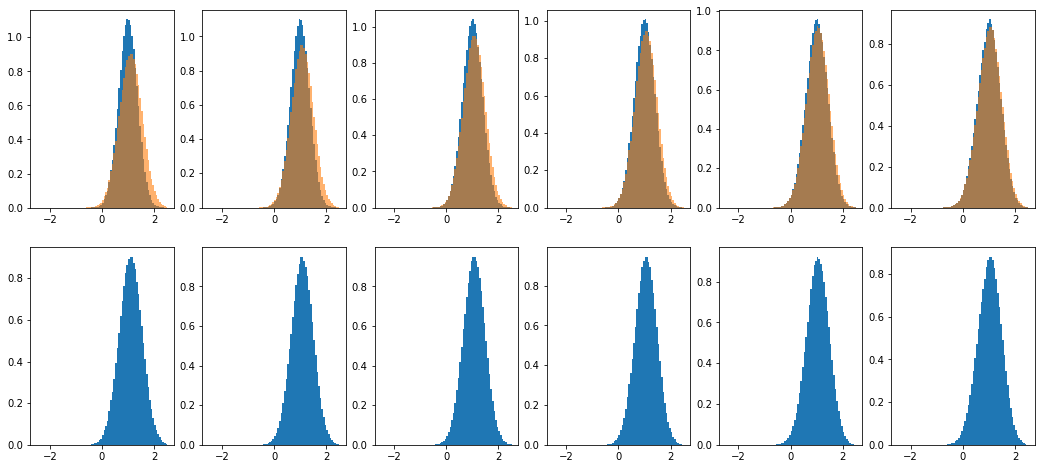

In [27]:
fig,ax = plt.subplots(2,num_sf,figsize=(18,8))

nom_rms_vals = []
alt_rms_vals = []

nom_bias_vals = []
alt_bias_vals = []


for sfi in range(0, num_sf) :

    ax[0][sfi].hist( fixedmu_preds[sfi][:,1], bins=80, range=[-2.5,2.5], density=True )
    ax[0][sfi].hist( alt_fixedmu_preds[sfi][:,1], bins=80, range=[-2.5,2.5], alpha=0.6, density=True)
    
    ax[1][sfi].hist( alt_fixedmu_preds[sfi][:,1], bins=80, range=[-2.5,2.5], density=True)
    
    mean = np.mean( fixedmu_preds[sfi][:,1] )
    rms = np.sqrt( np.mean( np.square( fixedmu_preds[sfi][:,1] - mean)))
    nom_rms_vals.append( rms )
    nom_bias_vals.append( mean - mu_val )
    
    alt_mean = np.mean( alt_fixedmu_preds[sfi][:,1] )
    alt_rms = np.sqrt( np.mean( np.square( alt_fixedmu_preds[sfi][:,1] - alt_mean)))
    alt_rms_vals.append( alt_rms )
    alt_bias_vals.append( alt_mean - mu_val )
 
    print("  nom SF %d :  mean = %7.3f, rms = %7.3f" % (sfi, mean, rms))
    print("  alt SF %d :  mean = %7.3f, rms = %7.3f\n" % (sfi, alt_mean, alt_rms))



<function matplotlib.pyplot.show(close=None, block=None)>

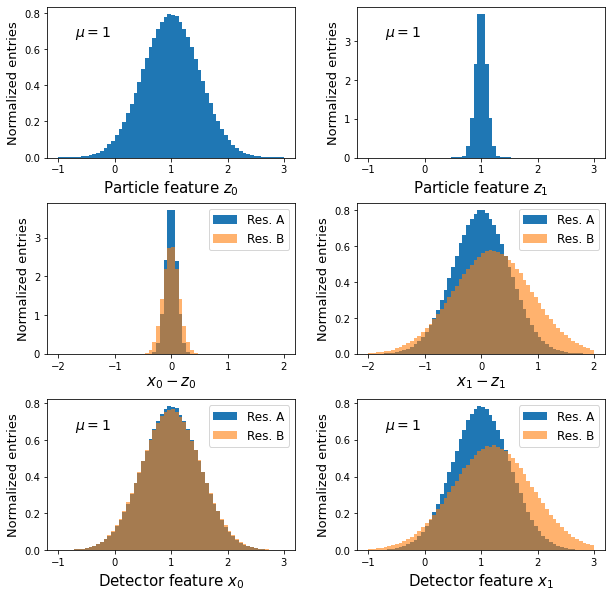

In [28]:
fig,ax = plt.subplots(3,2,figsize=(10,10))

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

nbins=60



ax[0][0].hist( fixedmu_z0, bins=nbins, range=[-2+mu_val,2+mu_val], density=True )
ax[0][1].hist( fixedmu_z1, bins=nbins, range=[-2+mu_val,2+mu_val], density=True )

ax[1][0].hist( resfun_x0, bins=nbins, range=[-2.,2.], density=True, label='Res. A' )
ax[1][1].hist( resfun_x1, bins=nbins, range=[-2.,2.], density=True, label='Res. A' )

ax[1][0].hist( alt_resfun_x0, bins=nbins, range=[-2.,2.], density=True, alpha=0.6, label='Res. B' )
ax[1][1].hist( alt_resfun_x1, bins=nbins, range=[-2.,2.], density=True, alpha=0.6, label='Res. B' )


ax[2][0].hist( fixedmu_x0, bins=nbins, range=[-2+mu_val,2+mu_val], density=True, label='Res. A' )
ax[2][1].hist( fixedmu_x1, bins=nbins, range=[-2+mu_val,2+mu_val], density=True, label='Res. A' )

ax[2][0].hist( alt_fixedmu_x0, bins=nbins, range=[-2+mu_val,2+mu_val], density=True, alpha=0.6, label='Res. B' )
ax[2][1].hist( alt_fixedmu_x1, bins=nbins, range=[-2+mu_val,2+mu_val], density=True, alpha=0.6, label='Res. B' )





xlabel_fontsize = 15
ylabel_fontsize = 13

ax[0][0].set_xlabel( 'Particle feature $z_0$', fontsize=xlabel_fontsize )
ax[0][1].set_xlabel( 'Particle feature $z_1$', fontsize=xlabel_fontsize )

ax[1][0].set_xlabel( '$x_0 - z_0$', fontsize=xlabel_fontsize )
ax[1][1].set_xlabel( '$x_1 - z_1$', fontsize=xlabel_fontsize )

ax[2][0].set_xlabel( 'Detector feature $x_0$', fontsize=xlabel_fontsize )
ax[2][1].set_xlabel( 'Detector feature $x_1$', fontsize=xlabel_fontsize )



ax[0][0].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )
ax[0][1].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )

ax[1][0].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )
ax[1][1].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )

ax[2][0].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )
ax[2][1].set_ylabel( 'Normalized entries', fontsize=ylabel_fontsize )


ax[0][0].text( -0.7, 0.80*ax[0][0].get_ylim()[1], '$\mu = %.0f$' % mu_val, fontsize=14 )
ax[0][1].text( -0.7, 0.80*ax[0][1].get_ylim()[1], '$\mu = %.0f$' % mu_val, fontsize=14 )

ax[2][0].text( -0.7, 0.80*ax[2][0].get_ylim()[1], '$\mu = %.0f$' % mu_val, fontsize=14 )
ax[2][1].text( -0.7, 0.80*ax[2][1].get_ylim()[1], '$\mu = %.0f$' % mu_val, fontsize=14 )




ax[1][0].legend( loc='best', fontsize=12 )
ax[1][1].legend( loc='best', fontsize=12 )

ax[2][0].legend( loc='best', fontsize=12 )
ax[2][1].legend( loc='best', fontsize=12 )



plt.savefig( 'toy-regression-features.png', bbox_inches='tight' )
plt.savefig( 'toy-regression-features.pdf', bbox_inches='tight' )


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

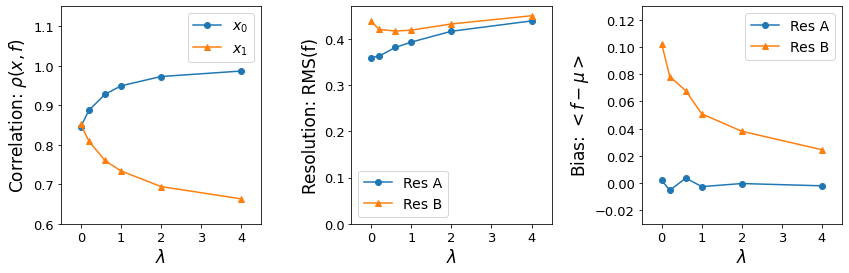

In [30]:
fig,ax = plt.subplots(1,3,figsize=(14,4))

plt.subplots_adjust( wspace=0.45)

plt.rc( 'xtick', labelsize=13)
plt.rc( 'ytick', labelsize=13)


ax[0].plot( sf_val, rho_x0_nnx_vals, marker="o", label='$x_0$' )
ax[0].plot( sf_val, rho_x1_nnx_vals, marker="^", label='$x_1$' )

ax[0].set_xlim(-0.5,4.5)
ax[0].set_ylim(0.60,1.15)



ax[1].plot( sf_val, nom_rms_vals, marker="o", label='Res A' )
ax[1].set_xlim(-0.5,4.5)
ax[1].set_ylim(0.0,0.47)

ax[1].plot( sf_val, alt_rms_vals, marker="^", label='Res B' )





ax[2].plot( sf_val, nom_bias_vals, marker="o", label='Res A' )
ax[2].set_xlim(-0.5,4.5)
ax[2].set_ylim(-0.03,0.13)

ax[2].plot( sf_val, alt_bias_vals, marker="^", label='Res B' )





xlabel_fontsize = 17
ylabel_fontsize = 17


ax[0].set_xlabel( '$\lambda$', fontsize=xlabel_fontsize )
ax[1].set_xlabel( '$\lambda$', fontsize=xlabel_fontsize )
ax[2].set_xlabel( '$\lambda$', fontsize=xlabel_fontsize )


ax[0].set_ylabel( 'Correlation: $\\rho(x,f)$', fontsize=ylabel_fontsize )
ax[1].set_ylabel( 'Resolution: RMS(f)', fontsize=ylabel_fontsize )
ax[2].set_ylabel( 'Bias: $<f-\mu>$', fontsize=ylabel_fontsize )

ax[0].legend( loc='best', fontsize=14 )
ax[1].legend( loc='best', fontsize=14 )
ax[2].legend( loc='best', fontsize=14 )


plt.savefig( 'toy-regression-resolution.png', bbox_inches='tight' )
plt.savefig( 'toy-regression-resolution.pdf', bbox_inches='tight' )


plt.show